In [18]:
import nibabel

def read_train_exam(exam_nb):
    image = nibabel.load('./chaos/train/%02d-T2SPIR-src.nii.gz'%(exam_nb))
    mask = nibabel.load('./chaos/train/%02d-T2SPIR-mask.nii.gz'%(exam_nb))
    return image, mask

def read_test_exam(exam_nb):
    image = nibabel.load('./chaos/test/%02d-T2SPIR-src.nii.gz'%(exam_nb))
    return image


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize # from scipy.misc import imresize


In [116]:
img_rows,img_cols = 256,256
def preprocess(image):
    #shape (slide,256,256)
    image_ = np.ndarray((image.shape[2],img_rows,img_cols,1))
    for i in range(image.shape[2]):
        image_[i,:,:,0] = resize(image.get_data()[:,:,i],(img_rows,img_cols),mode='reflect',preserve_range=True,
                               anti_aliasing=True)            
    #print(image_.shape)
    return image_

In [40]:
image_1, mask_1 = read_train_exam(2)
t1 = preprocess(mask_1)
print(np.unique(mask_1.get_data()[:,:,10]))

(26, 256, 256, 1)
[0 1 2 3]


In [129]:
def mask_to_channels(mask,classes):
    #get mask for each class
    img = np.asarray([np.where(mask == i,1,0 ) for i in range(classes)])
    img = np.swapaxes(img,0,-1)[0] #new shape (row,col,class)
    #print(img.shape)
    return img

(4, 320, 320)
(320, 320, 4)


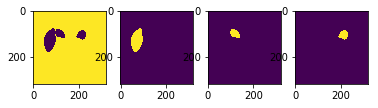

In [120]:
test = mask_1.get_data()[:,:,10]
img = mask_to_channels(test,4)
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(img[:,:,i])
plt.show()

(array([2497724.,       0.,  127587.,       0.,       0.,   10944.,
              0.,   11245.,       0.,   14900.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

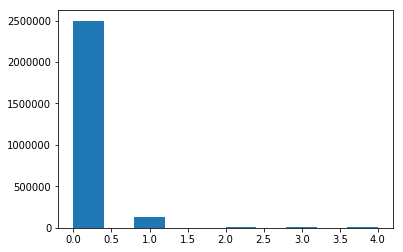

In [108]:
plt.hist(mask_1.get_data().flatten())

(array([1.603259e+06, 2.092000e+03, 7.592100e+04, 6.940000e+02,
        8.410000e+02, 5.938000e+03, 5.990000e+02, 6.207000e+03,
        3.550000e+02, 8.030000e+03]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

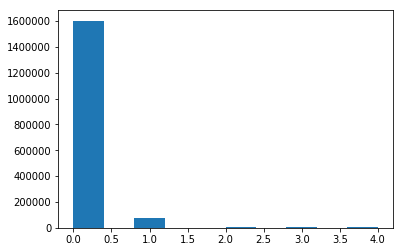

In [112]:
plt.hist(t1.flatten())

In [127]:
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
def get_data_train(train_ids = [1,2,3,5,8,10,13,19]):
    for idx, train_id in tqdm(enumerate(train_ids)):
        image, mask = read_train_exam(train_id)     
        image = preprocess(image)
        mask = preprocess(mask) 
        #transform le mask
        mask = mask_to_channels(mask,4)
        print("img {}, mask {}".format(image.shape,mask.shape))
        if idx > 0:
            train_data = np.concatenate((train_data, image),axis=0)
            train_mask = np.concatenate((train_mask, mask),axis=0)
        else:
            train_data = image
            train_mask = mask
    print("Final shape {},{}".format(train_data.shape,train_mask.shape))    
    np.savez_compressed('imgs_train', imgs=train_data,)
    np.savez_compressed('imgs_mask_train', imgs_mask=train_mask)

In [130]:
get_data_train()

1it [00:00,  3.55it/s]

img (36, 256, 256, 1), mask (36, 256, 256, 4)


2it [00:00,  3.34it/s]

img (26, 256, 256, 1), mask (26, 256, 256, 4)


3it [00:01,  3.02it/s]

img (30, 256, 256, 1), mask (30, 256, 256, 4)


4it [00:01,  2.89it/s]

img (30, 256, 256, 1), mask (30, 256, 256, 4)


5it [00:01,  2.55it/s]

img (32, 256, 256, 1), mask (32, 256, 256, 4)
img (36, 256, 256, 1), mask (36, 256, 256, 4)


6it [00:02,  2.18it/s]

img (30, 256, 256, 1), mask (30, 256, 256, 4)


7it [00:03,  2.00it/s]

img (30, 256, 256, 1), mask (30, 256, 256, 4)


8it [00:03,  1.87it/s]


Final shape (250, 256, 256, 1),(250, 256, 256, 4)


### plot images

In [131]:
img = np.load('imgs_train.npz')['imgs']
img_mask = np.load('imgs_mask_train.npz')['imgs_mask']


In [29]:
img[:,:,:].shape

(250, 256, 256, 1)

In [30]:
img[:,:,:,0].shape

(250, 256, 256)

In [31]:
#plot random samples from data
def plot_random_images(data,mask,size):
    index = np.random.choice(range(data.shape[0]),size)
    plt.figure(figsize=(20, 15))
    for i,x in enumerate(index):
        plt.subplot(1, len(index), i+1)
        plt.imshow(data[x,:,:,0], cmap='gray', interpolation='nearest')
        plt.imshow(mask[x,:,:,0], cmap='jet', alpha=0.5)
    plt.show()

Training data


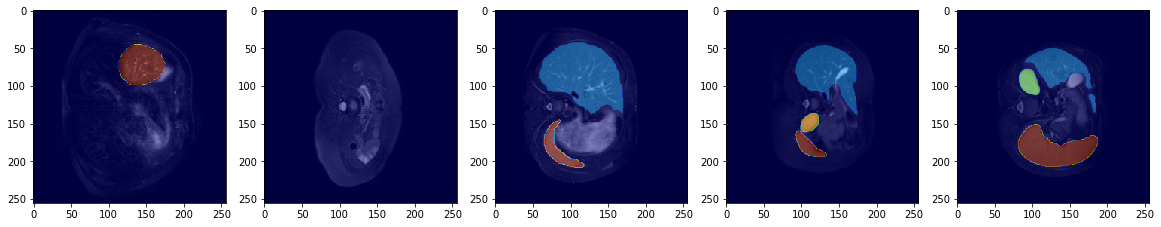

In [37]:
#plot random samples from training data
print("Training data")
plot_random_images(img,img_mask,5)

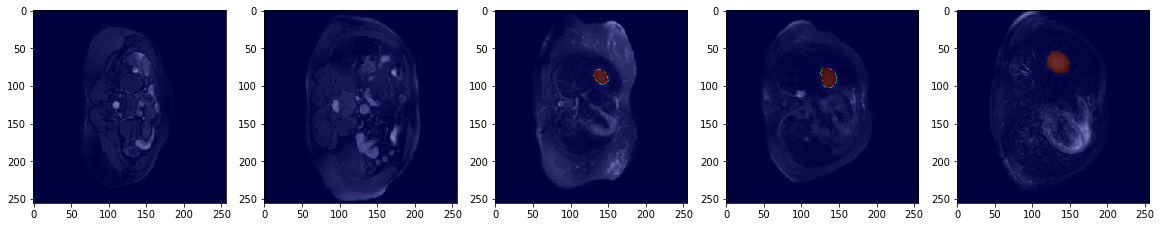

In [33]:
plot_random_images(img,img_mask,5)

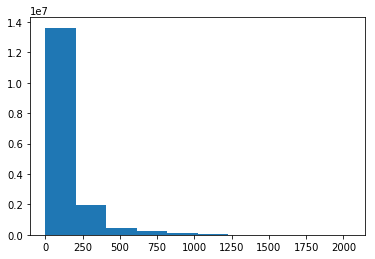

In [35]:
x = plt.hist(img.flatten())

In [34]:
imgs_train = img.astype('float32')
mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization

imgs_train -= mean
imgs_train /= std

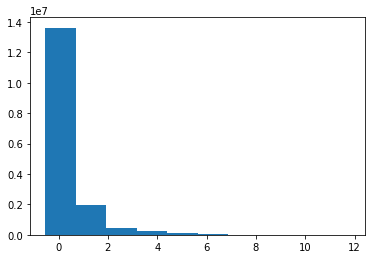

In [36]:
x = plt.hist(imgs_train.flatten())

In [140]:
img.reshape(-1,250).shape

(65536, 250)

(array([1.3615472e+07, 1.9484520e+06, 4.6121900e+05, 2.2555000e+05,
        9.3343000e+04, 2.4610000e+04, 8.6220000e+03, 4.9940000e+03,
        1.4530000e+03, 2.8500000e+02]),
 array([   0. ,  204.3,  408.6,  612.9,  817.2, 1021.5, 1225.8, 1430.1,
        1634.4, 1838.7, 2043. ], dtype=float32),
 <a list of 10 Patch objects>)

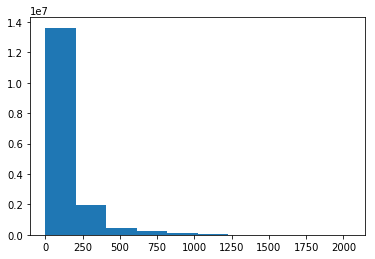

In [134]:
plt.hist(imgs_train.flatten())